In [1]:
import pandas as pd
import math
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('bmh')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 40, 30

# import plotly.offline as py
# import cufflinks as cf
# color = sns.color_palette()
# import plotly.graph_objs as go
# py.init_notebook_mode(connected=True)
# import plotly.tools as tls
# import random
# cf.set_config_file(offline=True, world_readable=True, theme='ggplot')


In [2]:
train=pd.read_csv("dataset/dengue_features_train.csv")
label=pd.read_csv("dataset/dengue_labels_train.csv")

In [3]:
train_df=train.copy()
label_df=label.copy()

In [4]:
print("train shape",train_df.shape)
print("label shape",label_df.shape)

train shape (1456, 24)
label shape (1456, 4)


In [5]:
def joins(train_df,label):
    df = pd.merge(train_df, label, how='left', on=['city','year', 'weekofyear'])
    print(df.shape)
    return df

In [6]:
def celsius(df,columns):
    for column in columns:
        t=column.split('_')
        del t[len(t)-1]
        t.append('c')
        newcol='_'.join(t)
        df[newcol]=df[column].apply(lambda x : x-273.15 )
    return df

In [7]:
def convertlist():
    columns=['reanalysis_dew_point_temp_k','reanalysis_air_temp_k','reanalysis_avg_temp_k','reanalysis_min_air_temp_k','reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']
    return columns

In [8]:
def preprocess(df):
    df['reanalysis_tdtr_c']=df['reanalysis_max_air_temp_c']-df['reanalysis_min_air_temp_c']
    return df


In [9]:
def drop(df):
    df=df.drop(['week_start_date','reanalysis_dew_point_temp_k','reanalysis_air_temp_k','reanalysis_avg_temp_k','reanalysis_min_air_temp_k','reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_tdtr_k'],axis=1)
    return df

In [10]:
def leb(df):
    lb=LabelEncoder()
    df['city']=lb.fit_transform(df['city'])
    return df,lb

In [11]:
def ileb(df,lb):
    df['city']=lb.inverse_transform(df['city'])
    return df

In [12]:
def imputevalues(df):
   # print(len(df))
    wantedcolumnlist=[]
    columnlist=df.columns.tolist()
    #print(len(columnlist))
    for i in range(len(columnlist)):
        columnname=columnlist[i]
        nan_rows = df[columnname].isnull().sum()
     #   print(i,nan_rows)
        nullcount=(nan_rows/len(df))*100
        #print(nullcount)
        if nullcount!=0:
            df[columnname]=df[columnname].fillna(df[columnname].mean()) 
        else:
            pass    
      
    
    return df

In [13]:
def split(df):
    features = df.drop(["total_cases"], axis=1).columns
    df_train, df_val = train_test_split(df, test_size=0.20,random_state=42)
    print("df_train shape",df_train.shape,"\ndf_val shape",df_val.shape)
    return df_train,df_val,features

In [14]:
def testread():
    test=pd.read_csv("dataset/dengue_features_test.csv")
    return test

In [15]:
df=joins(train_df,label)

(1456, 25)


In [16]:
columns=convertlist()

In [17]:
columns

['reanalysis_dew_point_temp_k',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k']

In [18]:
df=celsius(df,columns)

In [19]:
df=preprocess(df)

In [20]:
df=drop(df)

In [21]:
df=imputevalues(df)

In [22]:
df,lb=leb(df)

In [23]:
def is_chances(features):
   
    coolest = []
    warmest=[]
    normal=[]
    
    for observation in features['station_avg_temp_c']:
       # print(observation)
        if int(observation) > 28:
            warmest.append(1)
        else:
            warmest.append(0)
            
    for observation in features['station_avg_temp_c']:
        if observation < 24:
            coolest.append(1)
        else:
            coolest.append(0)  
            
    for observation in features['station_avg_temp_c']:
        if int(observation) > 24 & int(observation) <=28:
            normal.append(1)
        else:
            normal.append(0)

    return warmest,coolest,normal


In [24]:
warmest,coolest,normal = is_chances(df)

df['verywarm']=warmest
df['verycool']=coolest
df['normal']=normal

In [25]:
df_train,df_val,features=split(df)

df_train shape (1164, 27) 
df_val shape (292, 27)


In [26]:
test=testread()
test=celsius(test,columns)
test=preprocess(test)
test=drop(test)
test=imputevalues(test)

warmest,coolest,normal = is_chances(test)

test['verywarm']=warmest
test['verycool']=coolest
test['normal']=normal


#test,lbs=leb(test)

In [27]:
Regressor = [
        
        RandomForestRegressor(n_estimators=150,max_depth=18,min_weight_fraction_leaf=0.002),
        LGBMRegressor(objective='regression',num_leaves=31, learning_rate=0.01,n_estimators=150),
        XGBRegressor(max_depth=18,learning_rate=0.01,subsample=1,colsample_bylevel=1,colsample_bytree=1,n_estimators=200,min_child_weight=5,seed=25),
        GradientBoostingRegressor()
    ]

In [28]:
Accuracy=[]
Model=[]

for regressor in Regressor:
    try:
        test,lbs=leb(test)
        fit = regressor.fit(df_train[features], df_train["total_cases"])
        pred = fit.predict(df_val[features])
    except Exception:
        fit = regressor.fit(df_train[features], df_train["total_cases"])
        pred = fit.predict(df_val[features])
        
        
    score = regressor.score(df_val[features], df_val["total_cases"])
    Model.append(regressor.__class__.__name__)
    print('Accuracy of '+regressor.__class__.__name__+' is '+str(score))
    print("************************************************************")
    val_actual=np.array(df_val["total_cases"])
    val_pred=np.array(pred)
    error=(val_actual-val_pred)**2
    error_mean=round(np.mean(error))
    error_sq=math.sqrt(error_mean)
    
    
    
    print(regressor.__class__.__name__+" RMSE is "+str(error_sq))
    
#     predictions = fit.predict(test[features])
#     p=predictions.astype('int')
#     test['total_cases']=p
#     test['city']=ileb(test,lbs)
#     test[['city','year','weekofyear','total_cases']].to_csv("dataset/submission "+regressor.__class__.__name__+".csv" ,index=False)

Accuracy of RandomForestRegressor is 0.639347799357
************************************************************
RandomForestRegressor RMSE is 34.02939905434711
Accuracy of LGBMRegressor is 0.486091178831
************************************************************
LGBMRegressor RMSE is 40.620192023179804
Accuracy of XGBRegressor is 0.579954465498
************************************************************
XGBRegressor RMSE is 36.71511950137164
Accuracy of GradientBoostingRegressor is 0.641577909926
************************************************************
GradientBoostingRegressor RMSE is 33.926390907374746


In [29]:
### save best model
gbr = GradientBoostingRegressor()
fit = gbr.fit(df_train[features], df_train["total_cases"])
pickle.dump(fit,open( "disease_mode.pickle", "wb" ) )

### save label encoder 
pickle.dump(lb,open( "disease_label_encoder.pickle","wb"))


Text(0.5,1,'Correlation between different fearures')

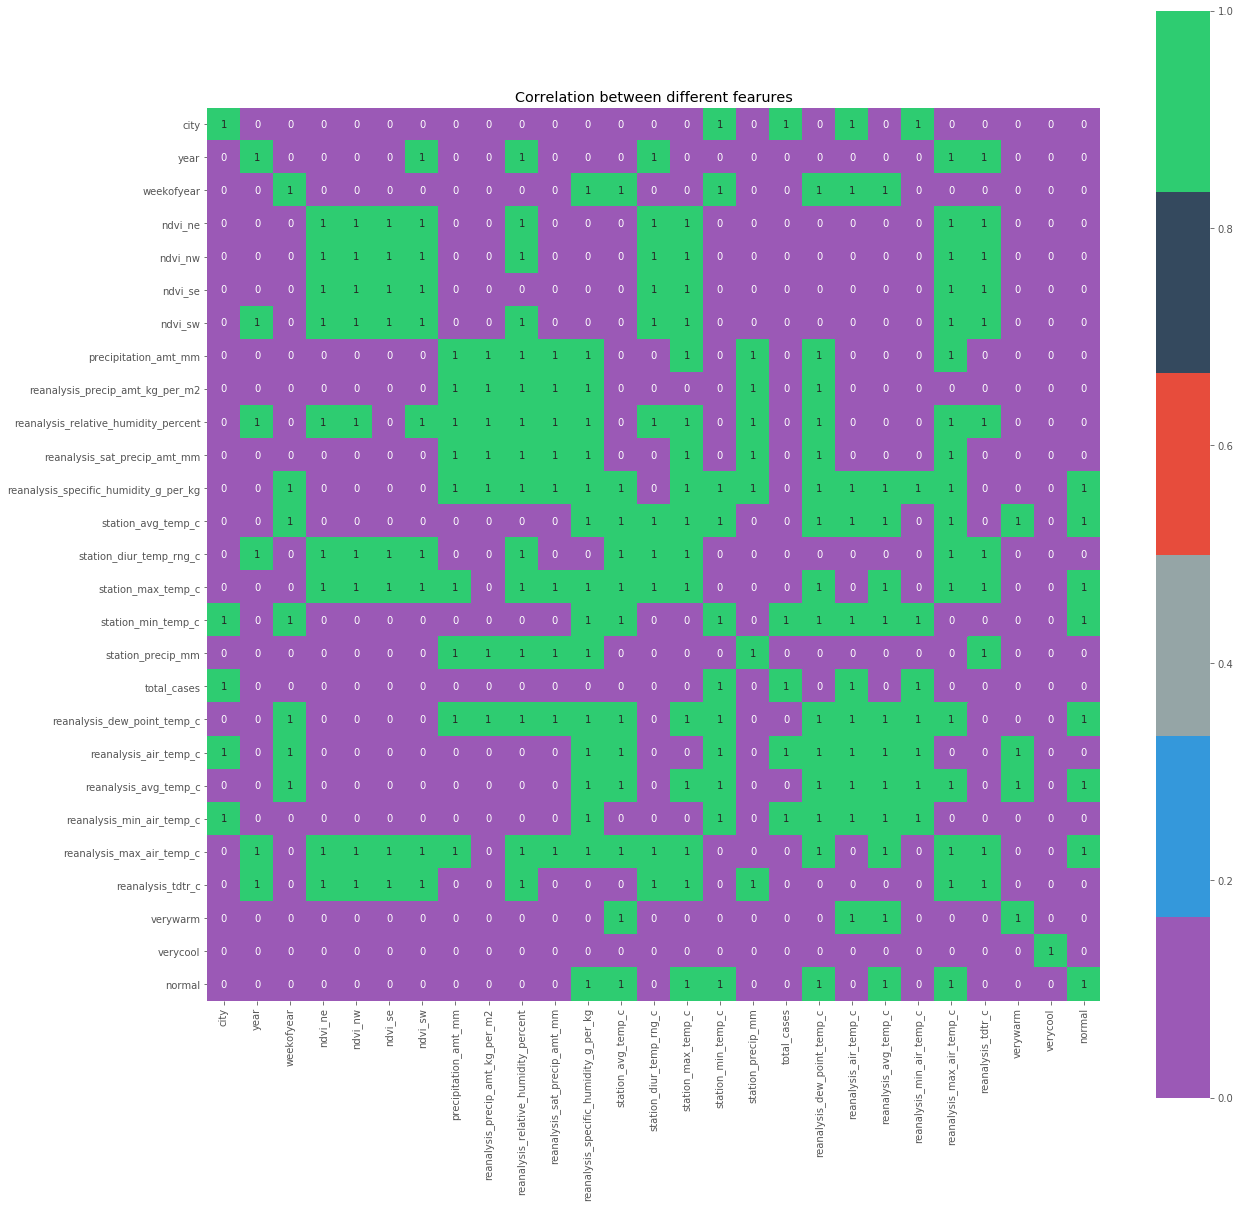

In [30]:
correlation=df.corr()
plt.figure(figsize=(20,20))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.heatmap(correlation>0.25 , vmax=1, square=True,annot=True,cmap=flatui)
plt.title('Correlation between different fearures')

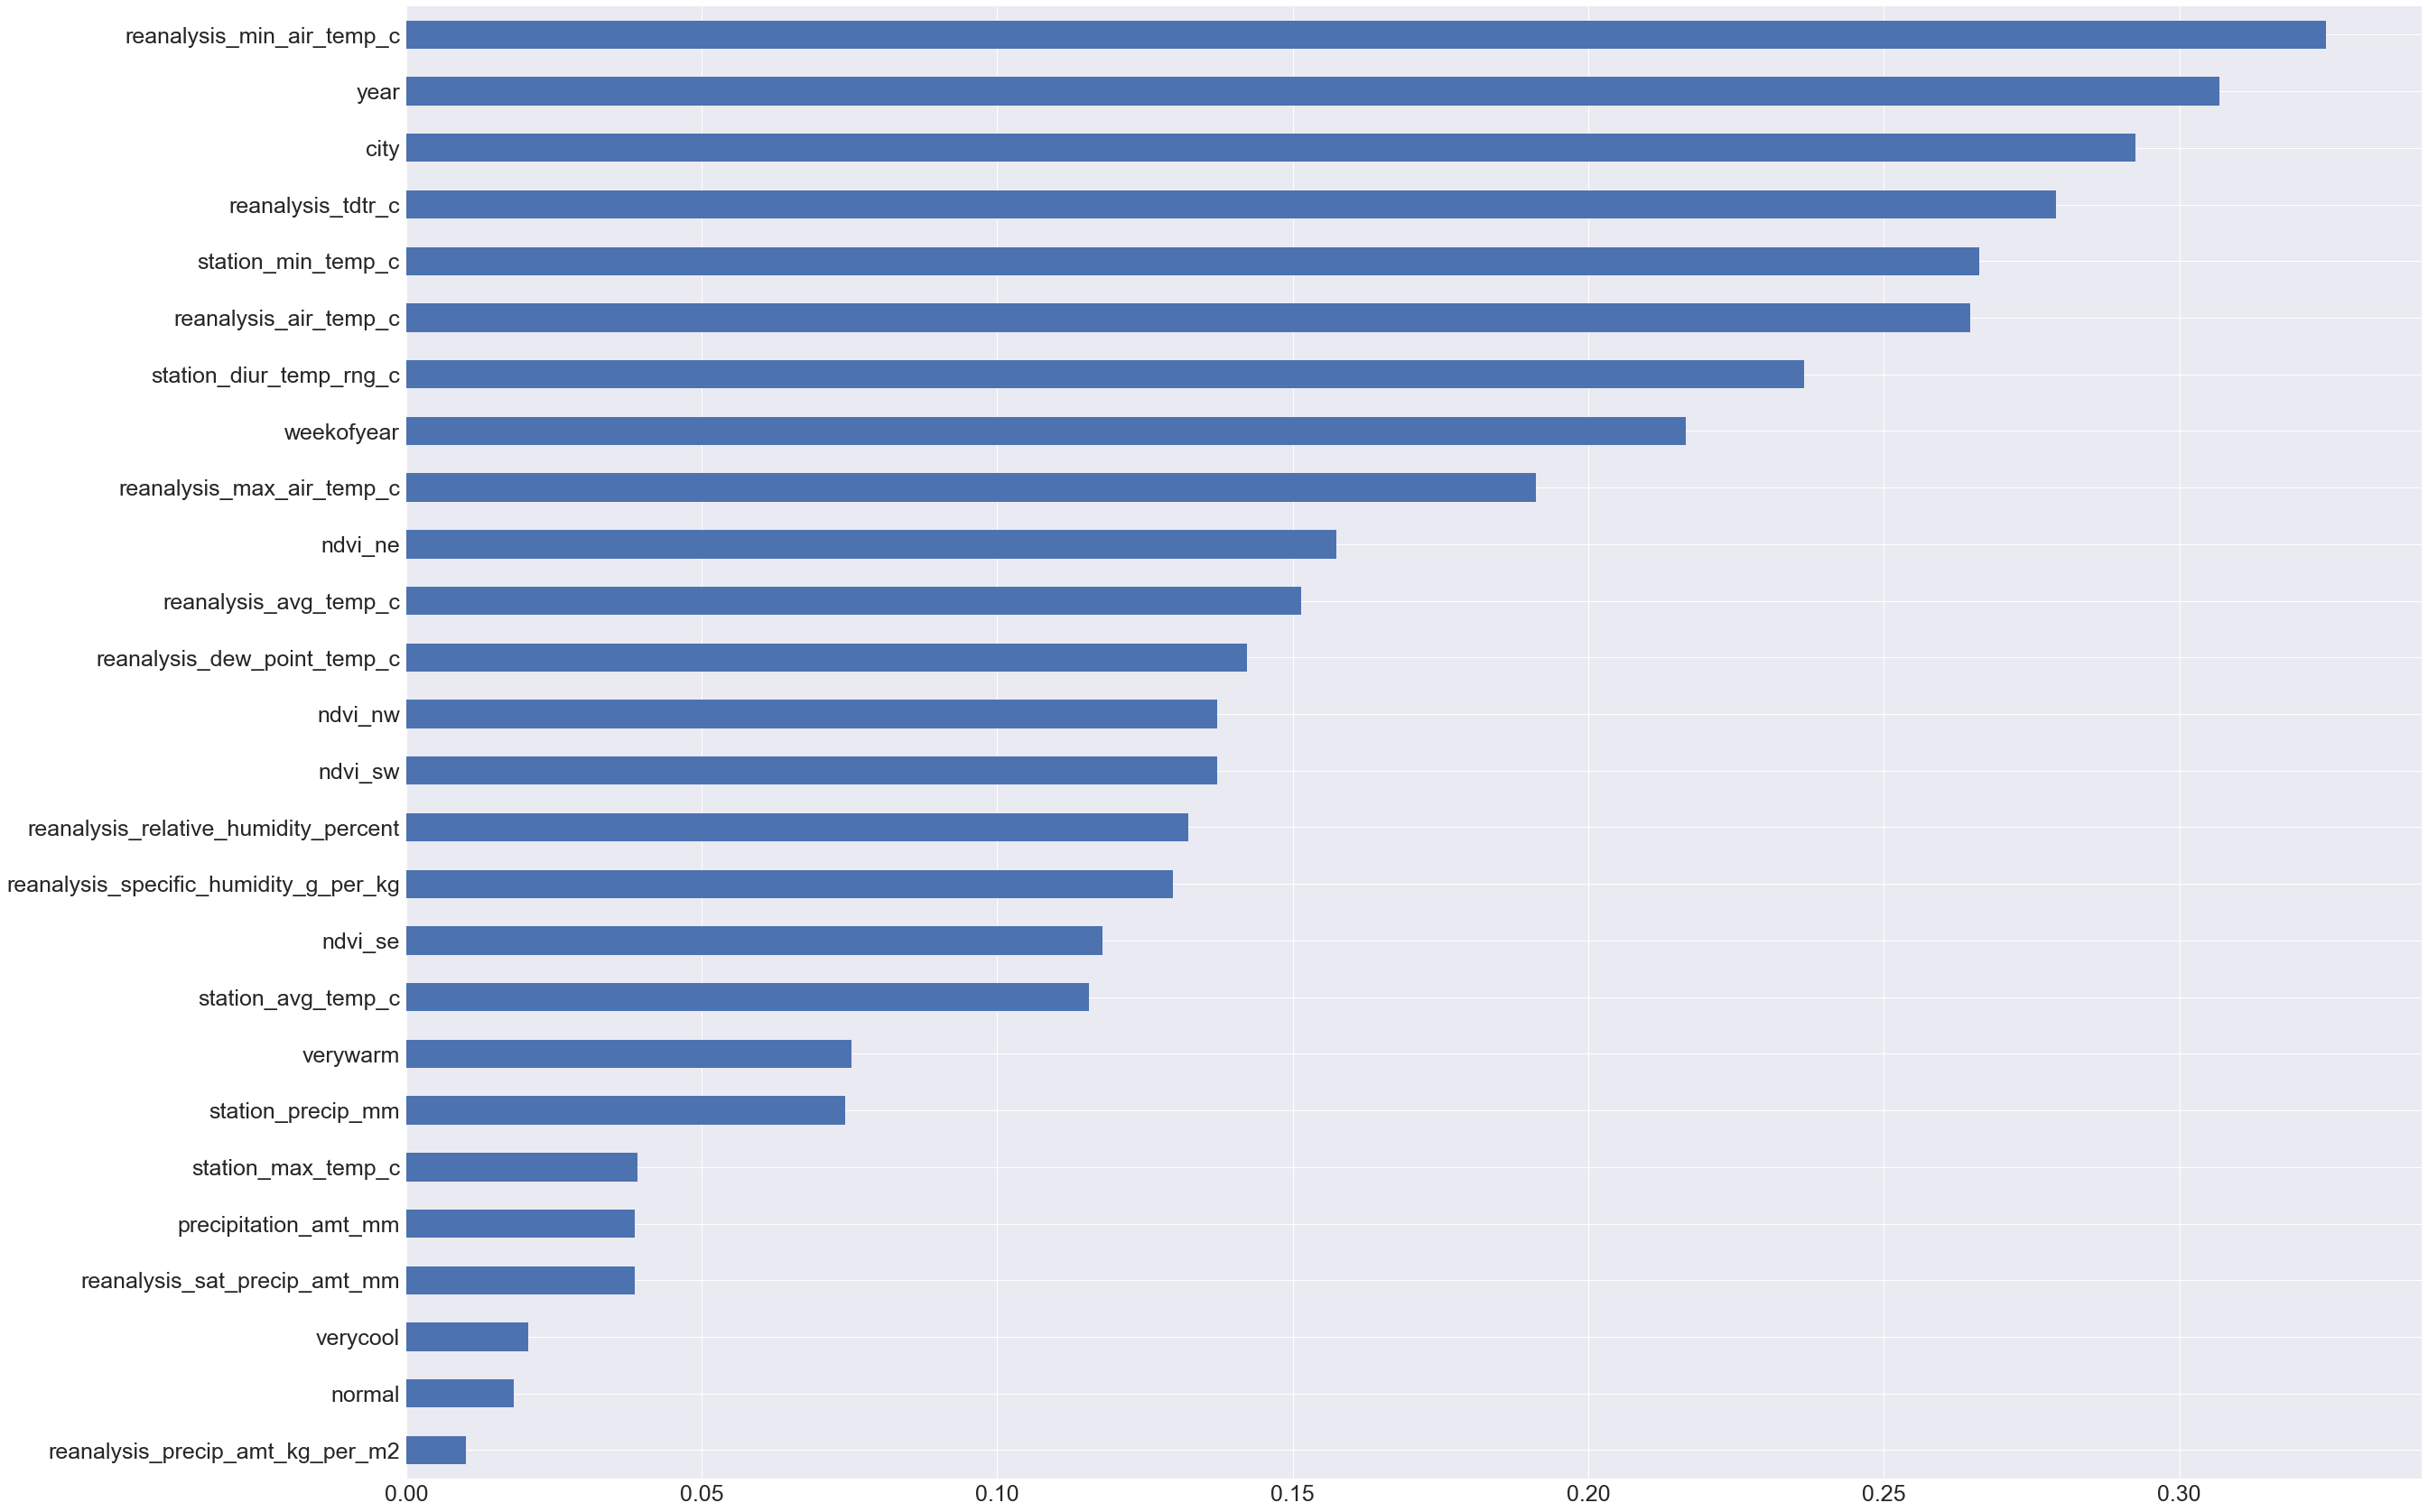

In [31]:
sns.set(font_scale = 2.5)
(abs(correlation)
 .total_cases
 .drop('total_cases')
 .sort_values()
 .plot
 .barh())